In [1790]:
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.cluster.vq import vq
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data

In [1791]:
hmpLabels = ['Brush_teeth', 'Climb_stairs', 'Comb_hair', 'Descend_stairs', 'Drink_glass', 'Eat_meat', 'Eat_soup', 'Getup_bed', 'Liedown_bed',
             'Pour_water', 'Sitdown_chair', 'Standup_chair', 'Use_telephone', 'Walk']

In [1792]:
hmpData = {}

for label in hmpLabels:
    path = 'data/HMP_Dataset/' + label + '/*.txt'
    files = glob.glob(path)
    
    hmpData[label] = []
    
    for file in files:
        fileData = pd.read_csv(file, sep=" ", header=None).values
        hmpData[label].append(fileData)   

# Segmentation

In [1793]:
def segmentData(data, segmentSize):
    segmentSize = segmentSize * 3                     # Each reading is actually 3 numbers - need to account that in segmentation
    incompleteSegmentData = len(data) % segmentSize   # We need to truncate last x rows that don't make a complete segment
    data = data[:len(data) - incompleteSegmentData]
    dataArr = np.array(data)                          # Convert to numpy array to enable easier transformation
    dataArr = np.reshape(dataArr, (-1, segmentSize))  # Do the segmentation
    return dataArr

In [1794]:
def segmentAndSplitData(trainSize, segmentSize, supressOutput = 'No'):
    if (supressOutput == 'No'):
        print ("Using segment size", segmentSize, "and train size", trainSize)
        print ('Segmenting classes')
    
    allTrainDataSegmented = []
    allTrainLabels = []
    allTrainFileIdentifiers = []
    allTestDataSegmented = []
    allTestLabels = []
    allTestFileIdentifiers = []
    uniqueTrainFileCtr = 0
    uniqueTestFileCtr = 0
    
    totalFilesAcrossClasses = 0
    totalTrainFilesAcrossClasses = 0
    totalTestFilesAcrossClasses = 0
    
    for hmpClass in hmpLabels: 
        totalFiles = len(hmpData[hmpClass])
        trainFiles = int(round(totalFiles * trainSize))
        testFiles = totalFiles - trainFiles
        if (supressOutput == 'No'):
            print (hmpClass, '| Total files:', totalFiles, '|', trainFiles, "training |", testFiles, "testing)")
        
        # Calculate totals for files across all classes
        totalFilesAcrossClasses = totalFilesAcrossClasses + totalFiles
        totalTrainFilesAcrossClasses = totalTrainFilesAcrossClasses + trainFiles
        totalTestFilesAcrossClasses = totalTestFilesAcrossClasses + testFiles
          
        # Segment training data
        trainData = []
        for i in range(trainFiles):
            trainData = hmpData[hmpClass][i].flatten()
            trainDataSegmented = segmentData(trainData, segmentSize)

            for i in range(len(trainDataSegmented)):          # Assign unique file identifier to each segment
                allTrainFileIdentifiers.append(uniqueTrainFileCtr)
                allTrainLabels.append(hmpLabels.index(hmpClass))
            uniqueTrainFileCtr = uniqueTrainFileCtr + 1
                
            allTrainDataSegmented.extend(trainDataSegmented)
                       
        # Segment test data
        testData = []
        for i in range(trainFiles, totalFiles):
            testData = hmpData[hmpClass][i].flatten()
            testDataSegmented = segmentData(testData, segmentSize)            

            for i in range(len(testDataSegmented)):          # Assign unique file identifier to each segment
                allTestFileIdentifiers.append(uniqueTestFileCtr)
                allTestLabels.append(hmpLabels.index(hmpClass))
            uniqueTestFileCtr = uniqueTestFileCtr + 1
                
            allTestDataSegmented.extend(testDataSegmented)     
    
    allTrainDataSegmentedArr = np.array(allTrainDataSegmented)
    allTestDataSegmentedArr = np.array(allTestDataSegmented)
    allTrainFileIdentifiersArr = np.array(allTrainFileIdentifiers)
    allTrainLabelsArr = np.array(allTrainLabels)
    allTestLabelsArr = np.array(allTestLabels)    
    allTestFileIdentifiersArr = np.array(allTestFileIdentifiers)    
        
    if (supressOutput == 'No'):
        print ('Summary for all classes:')
        print (len(allTrainDataSegmentedArr), 'total training segments |',  len(allTestDataSegmentedArr), 'total test segments')
        print ('Total files:', totalFilesAcrossClasses, '|', totalTrainFilesAcrossClasses, "training |", totalTestFilesAcrossClasses, "testing)")    
    return allTrainDataSegmentedArr, allTrainLabelsArr, allTrainFileIdentifiersArr, allTestDataSegmentedArr, allTestLabelsArr, allTestFileIdentifiersArr

In [1820]:
trainSize = 2/3
segmentSize = 4
(trainDataSegmented, trainLabels, trainFileIdentifiers, testDataSegmented, testLabels, testFileIdentifiers) = segmentAndSplitData(trainSize, segmentSize)

Using segment size 4 and train size 0.6666666666666666
Segmenting classes
Brush_teeth | Total files: 12 | 8 training | 4 testing)
Climb_stairs | Total files: 102 | 68 training | 34 testing)
Comb_hair | Total files: 31 | 21 training | 10 testing)
Descend_stairs | Total files: 42 | 28 training | 14 testing)
Drink_glass | Total files: 100 | 67 training | 33 testing)
Eat_meat | Total files: 5 | 3 training | 2 testing)
Eat_soup | Total files: 3 | 2 training | 1 testing)
Getup_bed | Total files: 101 | 67 training | 34 testing)
Liedown_bed | Total files: 28 | 19 training | 9 testing)
Pour_water | Total files: 100 | 67 training | 33 testing)
Sitdown_chair | Total files: 100 | 67 training | 33 testing)
Standup_chair | Total files: 102 | 68 training | 34 testing)
Use_telephone | Total files: 13 | 9 training | 4 testing)
Walk | Total files: 100 | 67 training | 33 testing)
Summary for all classes:
71502 total training segments | 39814 total test segments
Total files: 839 | 561 training | 278 testi

# Clustering

In [1887]:
n_clusters = 14

In [1888]:
k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(trainDataSegmented)

In [1800]:
k_means.labels_

array([7, 7, 7, ..., 6, 6, 6])

In [ ]:
k_means.cluster_centers_

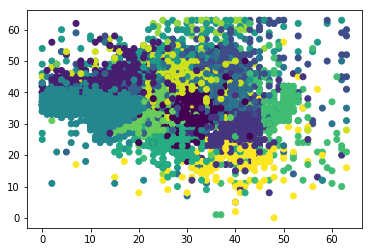

In [1802]:
plt.scatter(trainDataSegmented[:,0],trainDataSegmented[:,1], c=k_means.labels_)  

In [1517]:
# Agglomerative Clustering is another option
hierClustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

## Create a histogram of cluster centers to use as an input into the classifier

In [1889]:
def createTrainHistograms(model, n_clusters):
    unique, segmentCounts = np.unique(trainFileIdentifiers, return_counts=True)
    
    numFiles = len(np.unique(trainFileIdentifiers))

    trainFeatures = np.zeros(numFiles * (n_clusters + 1), dtype = int)
    trainFeatures = trainFeatures.reshape(numFiles, (n_clusters + 1))

    prevSegment = 0

    for i in range(len(np.unique(trainFileIdentifiers))):
        start = prevSegment
        end = prevSegment + segmentCounts[i]
        assignment = vq(trainDataSegmented[start:end], model.cluster_centers_) # Create vector with each segment assigned to a given cluster
        assignmentArr = np.array(assignment[0])
    
        feature = np.zeros(n_clusters + 1, dtype = 'int')
    
        assignmentArr = np.array(assignment[0])
        for j in assignmentArr:
            trainFeatures[i][j] += 1
    
        trainFeatures[i][n_clusters] = trainLabels[start]
    
        prevSegment = end
        
    return trainFeatures

In [1890]:
def createTestHistograms(model, n_clusters):
    unique, segmentCounts = np.unique(testFileIdentifiers, return_counts=True)
    
    numFiles = len(np.unique(testFileIdentifiers))

    testFeatures = np.zeros(numFiles * (n_clusters + 1), dtype = int)
    testFeatures = testFeatures.reshape(numFiles, (n_clusters + 1))

    prevSegment = 0

    for i in range(len(np.unique(testFileIdentifiers))):
        start = prevSegment
        end = prevSegment + segmentCounts[i]
        assignment = vq(testDataSegmented[start:end], model.cluster_centers_) # Create vector with each segment assigned to a given cluster
        assignmentArr = np.array(assignment[0])
    
        feature = np.zeros(n_clusters + 1, dtype = 'int')
    
        assignmentArr = np.array(assignment[0])
        for j in assignmentArr:
            testFeatures[i][j] += 1
    
        testFeatures[i][n_clusters] = testLabels[start]
    
        prevSegment = end
        
    return testFeatures

In [1891]:
trainFeatures = createTrainHistograms(k_means, n_clusters)
testFeatures = createTestHistograms(k_means, n_clusters)

In [1830]:
k_means.labels_

array([5, 5, 5, ..., 9, 9, 9])

In [ ]:
# trainFeaturesSummary = trainFeatures.sum(axis=0)

In [ ]:
#n, bins, patches = plt.hist(x=k_means.cluster_centers_[2], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.15)
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title(hmpLabels[0])

## Classification using Random Forest Classifier

In [1633]:
randomForestClassifier = RandomForestClassifier(max_depth=32, random_state=8, n_estimators=90)

In [1634]:
randomForestClassifier.fit(trainFeatures[0:, 0:n_clusters], trainFeatures[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

In [1635]:
prediction = randomForestClassifier.predict(testFeatures[0:, 0:n_clusters])

In [1636]:
accuracy = accuracy_score(testFeatures[:, -1], prediction)

In [1637]:
print("Classifier accuracy: " + str(round((accuracy * 100),2)) + "%")

Classifier accuracy: 67.66%


In [1638]:
print(confusion_matrix(testFeatures[:, -1], prediction))

[[ 2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 19  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  1  2  0  0 12  0  0  1  3  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0 10  7  0  0]
 [ 0  0  0  0  0  0  0  1  0  1 10  8  0  0]
 [ 0  0  0  0  1  0  0  0  0  1  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 20]]


# Results

## Page 1 (Experiment table)

In [1528]:
# Table listing the experiments carried out with the following columns. Size of the fixed length sample Overlap (0-X%) K-value Classifier Accuracy.
# We expect you to have tried at least 2 values of K and at least 2 different lengths of the windows for quantization.
# Note: For K-means please also list if you used standard K-means or hierarchical.

In [1925]:
clustersToTry = [4, 8, 14, 28, 50, 100]
segmentSizesToTry = [1, 2, 4, 8, 16, 32, 64]
inertia = []

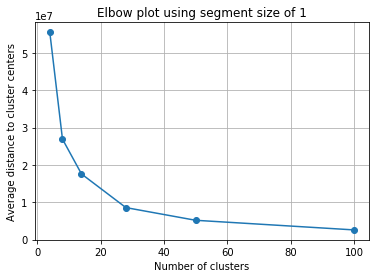

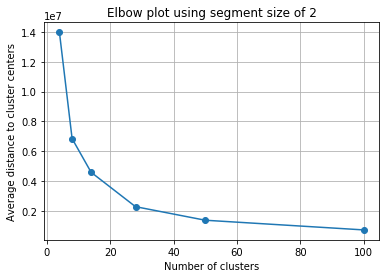

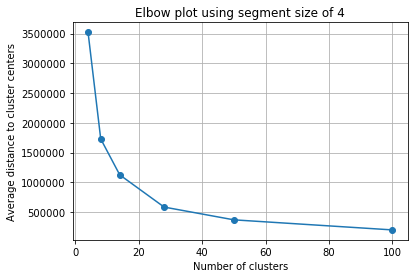

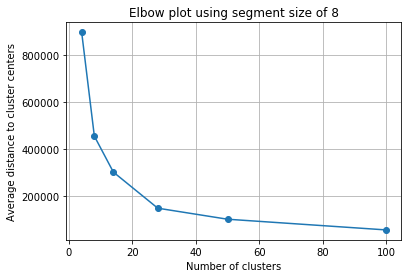

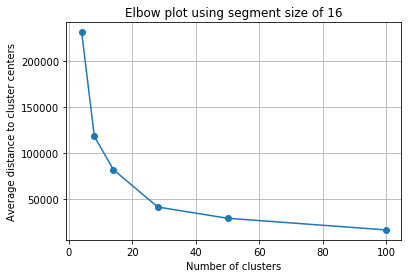

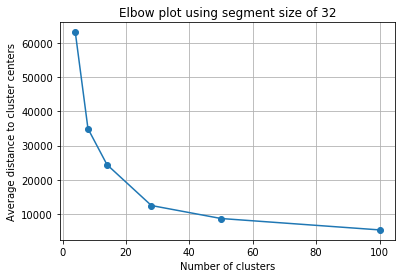

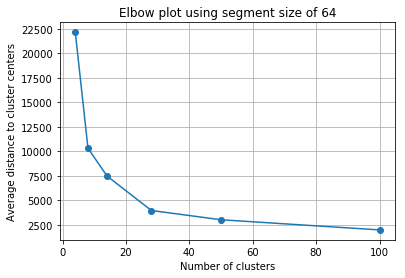

In [1928]:
for segmentSize in tqdm(segmentSizesToTry):
    inertia = []    
    for n_clusters in tqdm(clustersToTry):
        (trainDataSegmented, trainLabels, trainFileIdentifiers, testDataSegmented, testLabels, testFileIdentifiers) = segmentAndSplitData(trainSize, segmentSize, 'Yes')
        k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(trainDataSegmented)
        trainFeatures = createTrainHistograms(k_means, n_clusters)
        k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(trainFeatures)
        inertia.append(k_means.inertia_)
    
    plt.plot(clustersToTry, inertia, marker="o")
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance to cluster centers')
    plt.title('Elbow plot using segment size of ' + str(segmentSize))
    plt.grid(True)
    plt.show()

In [1732]:
trainSize = 2/3

In [1779]:
accPerClusterNumAndSegmentSize = []

for n_clusters in tqdm(clustersToTry):
    for segmentSize in tqdm(segmentSizesToTry):
        print ('Trying with', n_clusters, 'clusters and segment size', segmentSize)
        (trainDataSegmented, trainLabels, trainFileIdentifiers, testDataSegmented, testLabels, testFileIdentifiers) = segmentAndSplitData(trainSize, segmentSize, 'Yes')
        k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(trainDataSegmented)
        
        trainFeatures = createTrainHistograms(k_means, n_clusters)
        testFeatures = createTestHistograms(k_means, n_clusters)
        
        randomForestClassifier = RandomForestClassifier(max_depth = 32, random_state = 0)
        
        randomForestClassifier.fit(trainFeatures[0:, 0:n_clusters], trainFeatures[:, -1])
        prediction = randomForestClassifier.predict(testFeatures[0:, 0:n_clusters])
        accuracy = accuracy_score(testFeatures[:, -1], prediction)
        acc = (accuracy_score(testFeatures[:, -1], prediction))*100
        acc = round(float(acc), 4)
        print("Classifier accuracy: " + str(acc) + "%")
        accPerClusterNumAndSegmentSize.append([n_clusters, segmentSize, acc])
        # print(confusion_matrix(testFeatures[:, -1], prediction))

Trying with 4 clusters and segment size 1
Classifier accuracy: 64.0288%
Trying with 4 clusters and segment size 2
Classifier accuracy: 67.2662%
Trying with 4 clusters and segment size 4
Classifier accuracy: 64.0288%
Trying with 4 clusters and segment size 8
Classifier accuracy: 60.7914%
Trying with 4 clusters and segment size 16
Classifier accuracy: 61.1511%
Trying with 4 clusters and segment size 32
Classifier accuracy: 62.9496%
Trying with 4 clusters and segment size 64
Classifier accuracy: 53.9568%
Trying with 8 clusters and segment size 1
Classifier accuracy: 65.1079%
Trying with 8 clusters and segment size 2
Classifier accuracy: 66.9065%
Trying with 8 clusters and segment size 4
Classifier accuracy: 69.0647%
Trying with 8 clusters and segment size 8
Classifier accuracy: 68.3453%
Trying with 8 clusters and segment size 16
Classifier accuracy: 62.9496%
Trying with 8 clusters and segment size 32
Classifier accuracy: 65.1079%
Trying with 8 clusters and segment size 64
Classifier accur

In [ ]:
# print (np.matrix(accPerClusterNumAndSegmentSize))

In [1854]:
accPerClusterNumAndSegmentSize = np.array(accPerClusterNumAndSegmentSize)

In [1881]:
xs = accPerClusterNumAndSegmentSize[:, 0]
ys = accPerClusterNumAndSegmentSize[:, 1]
zs = accPerClusterNumAndSegmentSize[:, 2]

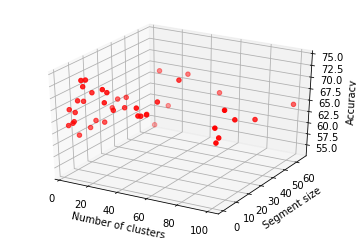

In [1886]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c='r', marker='o')

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Segment size')
ax.set_zlabel('Accuracy')

plt.show()

## Page 2 (Histograms)

In [1550]:
# Histograms of the mean quantized vector (Histogram of cluster centres like in the book) for each activity with the K value that gives you the highest accuracy.
# (Please state the K value)

In [1583]:
# fullFeatureSet = np.concatenate((trainFeatures, testFeatures))

## Page 3 Confusion matrix

In [1591]:
# Class confusion matrix from the classifier that you used.
# Please make sure to label the row/colums of the matrix so that we know which row corresponds to what.